# Task
Изучаю tradesBar историю с баром из 33000 сделок, сравниваю с обычной часовой историей

# Import modules

In [88]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
# warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import make_scorer, average_precision_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [90]:
dir_final = 'D:\\BinanceData\\FinalSaveData' # Путь к файлам
coin = 'eth' # Список инструментов для загрузки
# file_type = 'trades' 
trades_in_bar = 33000 # Сколько будет сделок в одном баре
trades_bar_name = str(trades_in_bar) + '_tradesBar'


In [91]:
dir_for_trades_bar_files = f'{dir_final}\\{trades_bar_name}\\{coin}\\'

trades_bar_file_name = coin.upper() + '_' + trades_bar_name + '.parquet'
trades_bar_file_path = os.path.join(dir_for_trades_bar_files, trades_bar_file_name)

leftover_file_name = coin.upper() + '_leftover' + '.parquet'
leftover_file_path = os.path.join(dir_for_trades_bar_files, leftover_file_name)

In [92]:
trades_bar_file_path

'D:\\BinanceData\\FinalSaveData\\33000_tradesBar\\eth\\ETH_33000_tradesBar.parquet'

In [93]:
data = pd.read_parquet(trades_bar_file_path)

In [94]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34450 entries, 0 to 34449
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Begin    34450 non-null  datetime64[ns]
 1   End      34450 non-null  datetime64[ns]
 2   Open     34450 non-null  float64       
 3   High     34450 non-null  float64       
 4   Low      34450 non-null  float64       
 5   Close    34450 non-null  float64       
 6   Vol      34450 non-null  float64       
 7   Vol_USD  34450 non-null  float64       
dtypes: datetime64[ns](2), float64(6)
memory usage: 2.1 MB


In [95]:
df

,Begin,End,Open,High,Low,Close,Vol,Vol_USD
0,2017-09-01 00:13:00.108,2017-09-05 15:39:42.915,386.44,394.39,235.55,292.57,31263.41283,1.027476e+07
1,2017-09-05 15:39:43.166,2017-09-14 04:11:01.466,292.57,342.50,257.05,270.00,39142.13691,1.176137e+07
2,2017-09-14 04:11:01.476,2017-09-18 09:41:54.248,270.00,299.00,192.00,285.00,43437.50092,1.069043e+07
3,2017-09-18 09:41:54.248,2017-09-26 05:51:41.729,285.00,306.22,252.10,289.42,23577.98218,6.697893e+06
4,2017-09-26 05:51:56.654,2017-09-29 14:50:43.138,289.42,313.00,274.00,294.00,24413.22692,7.208240e+06
...,...,...,...,...,...,...,...,...
34445,2023-04-23 15:14:23.803,2023-04-23 16:15:07.365,1860.00,1863.46,1847.94,1852.54,25615.26410,4.757427e+07
34446,2023-04-23 16:15:07.584,2023-04-23 17:50:13.896,1852.56,1872.69,1852.55,1857.59,20070.28670,3.741527e+07
34447,2023-04-23 17:50:13.896,2023-04-23 18:50:34.308,1857.59,1861.52,1836.37,1838.80,25799.06150,4.776911e+07
34448,2023-04-23 18:50:34.308,2023-04-23 20:02:52.571,1838.80,1852.35,1838.43,1840.21,25428.22350,4.694859e+07


# Base Visualization

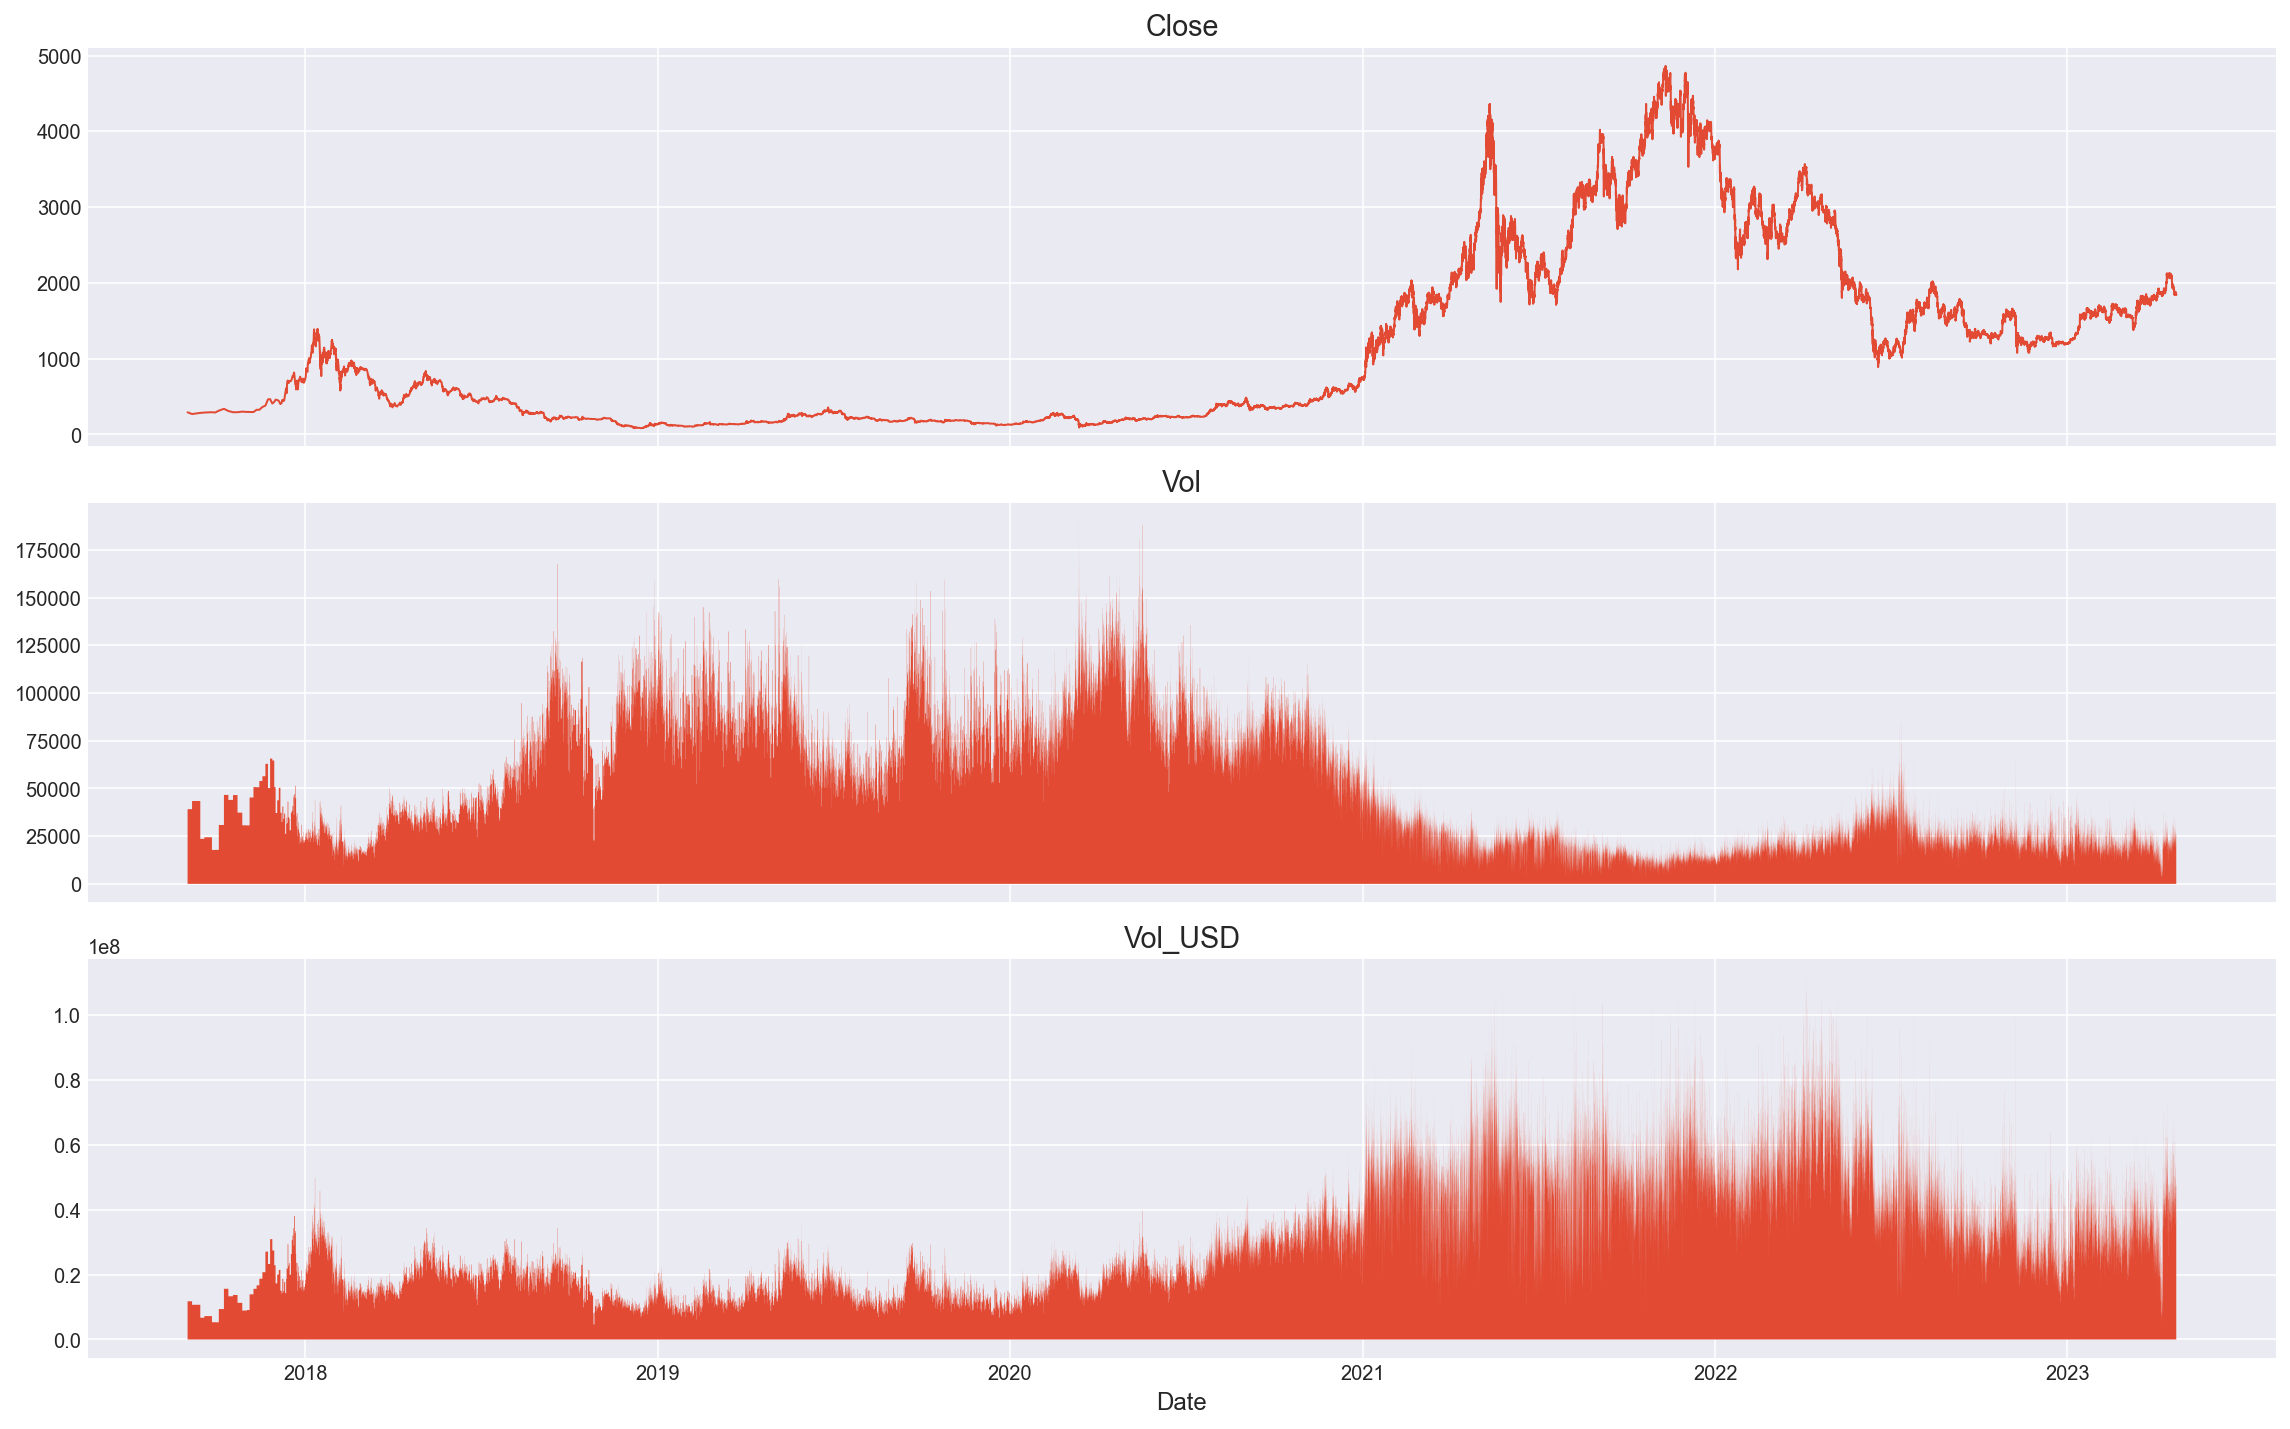

In [96]:
# If need to plot not all data
# df_to_plot = df[df['Begin'] >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot['Begin'].to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Vol'].to_numpy()
_2 = df_to_plot['Vol_USD'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Vol')

ax[2].fill_between(ind, _2, step='pre')
ax[2].set_title('Vol_USD')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Видно что долларовые объемы хоть и снизились, но выше чем до 20года

Все же подрежу историю с начала 18 года

In [97]:
df = df[df['Begin'] >= '2018-01-01'].copy()
df.reset_index(drop=True, inplace=True)

In [98]:
df

,Begin,End,Open,High,Low,Close,Vol,Vol_USD
0,2018-01-01 00:48:35.787,2018-01-01 11:12:22.106,723.94,763.55,716.80,738.98,23025.57574,1.709539e+07
1,2018-01-01 11:12:22.106,2018-01-01 21:34:01.595,740.77,762.62,724.15,761.98,24710.32761,1.833786e+07
2,2018-01-01 21:34:01.712,2018-01-02 02:34:01.753,761.98,899.50,749.06,873.00,26433.54333,2.166307e+07
3,2018-01-02 02:34:01.773,2018-01-02 08:04:04.176,873.00,873.00,817.00,845.00,28657.88170,2.418451e+07
4,2018-01-02 08:04:04.405,2018-01-02 15:32:28.691,845.00,866.65,825.11,860.00,26767.90672,2.270014e+07
...,...,...,...,...,...,...,...,...
34370,2023-04-23 15:14:23.803,2023-04-23 16:15:07.365,1860.00,1863.46,1847.94,1852.54,25615.26410,4.757427e+07
34371,2023-04-23 16:15:07.584,2023-04-23 17:50:13.896,1852.56,1872.69,1852.55,1857.59,20070.28670,3.741527e+07
34372,2023-04-23 17:50:13.896,2023-04-23 18:50:34.308,1857.59,1861.52,1836.37,1838.80,25799.06150,4.776911e+07
34373,2023-04-23 18:50:34.308,2023-04-23 20:02:52.571,1838.80,1852.35,1838.43,1840.21,25428.22350,4.694859e+07


Изучаю продолжительность баров

In [99]:
bar_len = df['End'] - df['Begin']
bar_len

0       0 days 10:23:46.319000
1       0 days 10:21:39.489000
2       0 days 05:00:00.041000
3       0 days 05:30:02.403000
4       0 days 07:28:24.286000
                 ...          
34370   0 days 01:00:43.562000
34371   0 days 01:35:06.312000
34372   0 days 01:00:20.412000
34373   0 days 01:12:18.263000
34374   0 days 02:08:44.305000
Length: 34375, dtype: timedelta64[ns]

Конвертирую в минуты

In [100]:
bar_len = (bar_len.dt.total_seconds() // 60).astype(int)
bar_len

0        623
1        621
2        300
3        330
4        448
        ... 
34370     60
34371     95
34372     60
34373     72
34374    128
Length: 34375, dtype: int32

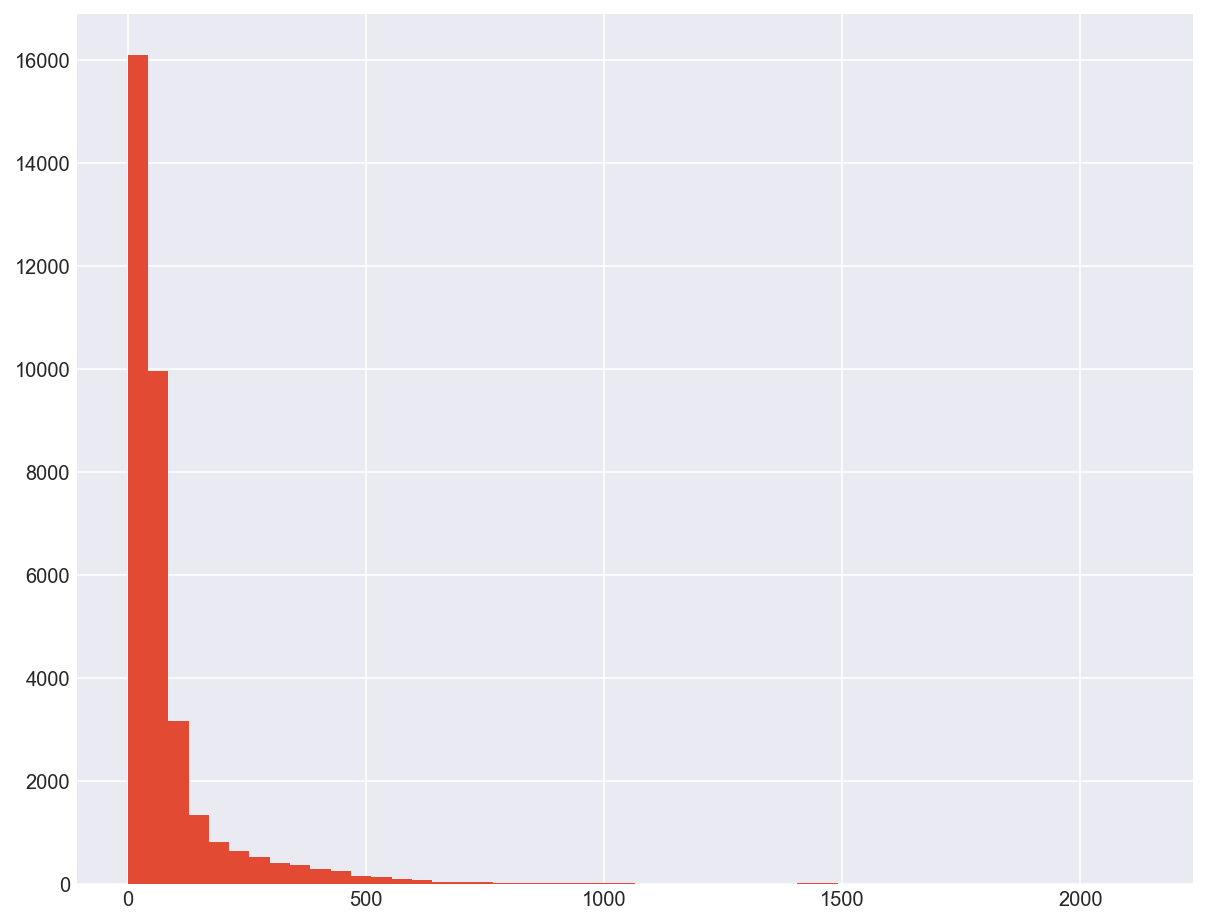

In [101]:
bar_len.hist(bins=50);

In [102]:
bar_len.describe()

count    34375.000000
mean        80.720436
std        108.304027
min          0.000000
25%         24.000000
50%         46.000000
75%         84.000000
max       2130.000000
dtype: float64

Распределение странное, есть бары, которые формировались 2130 часов

Добавлю серию в датафрейм отфильтрую, посмотрю что там за бары.

Удалю признак End, он лишний т.к. продолжительность баров уже вытащил из данных.

In [103]:
df['Duration'] = bar_len
df.drop(columns='End', inplace=True)

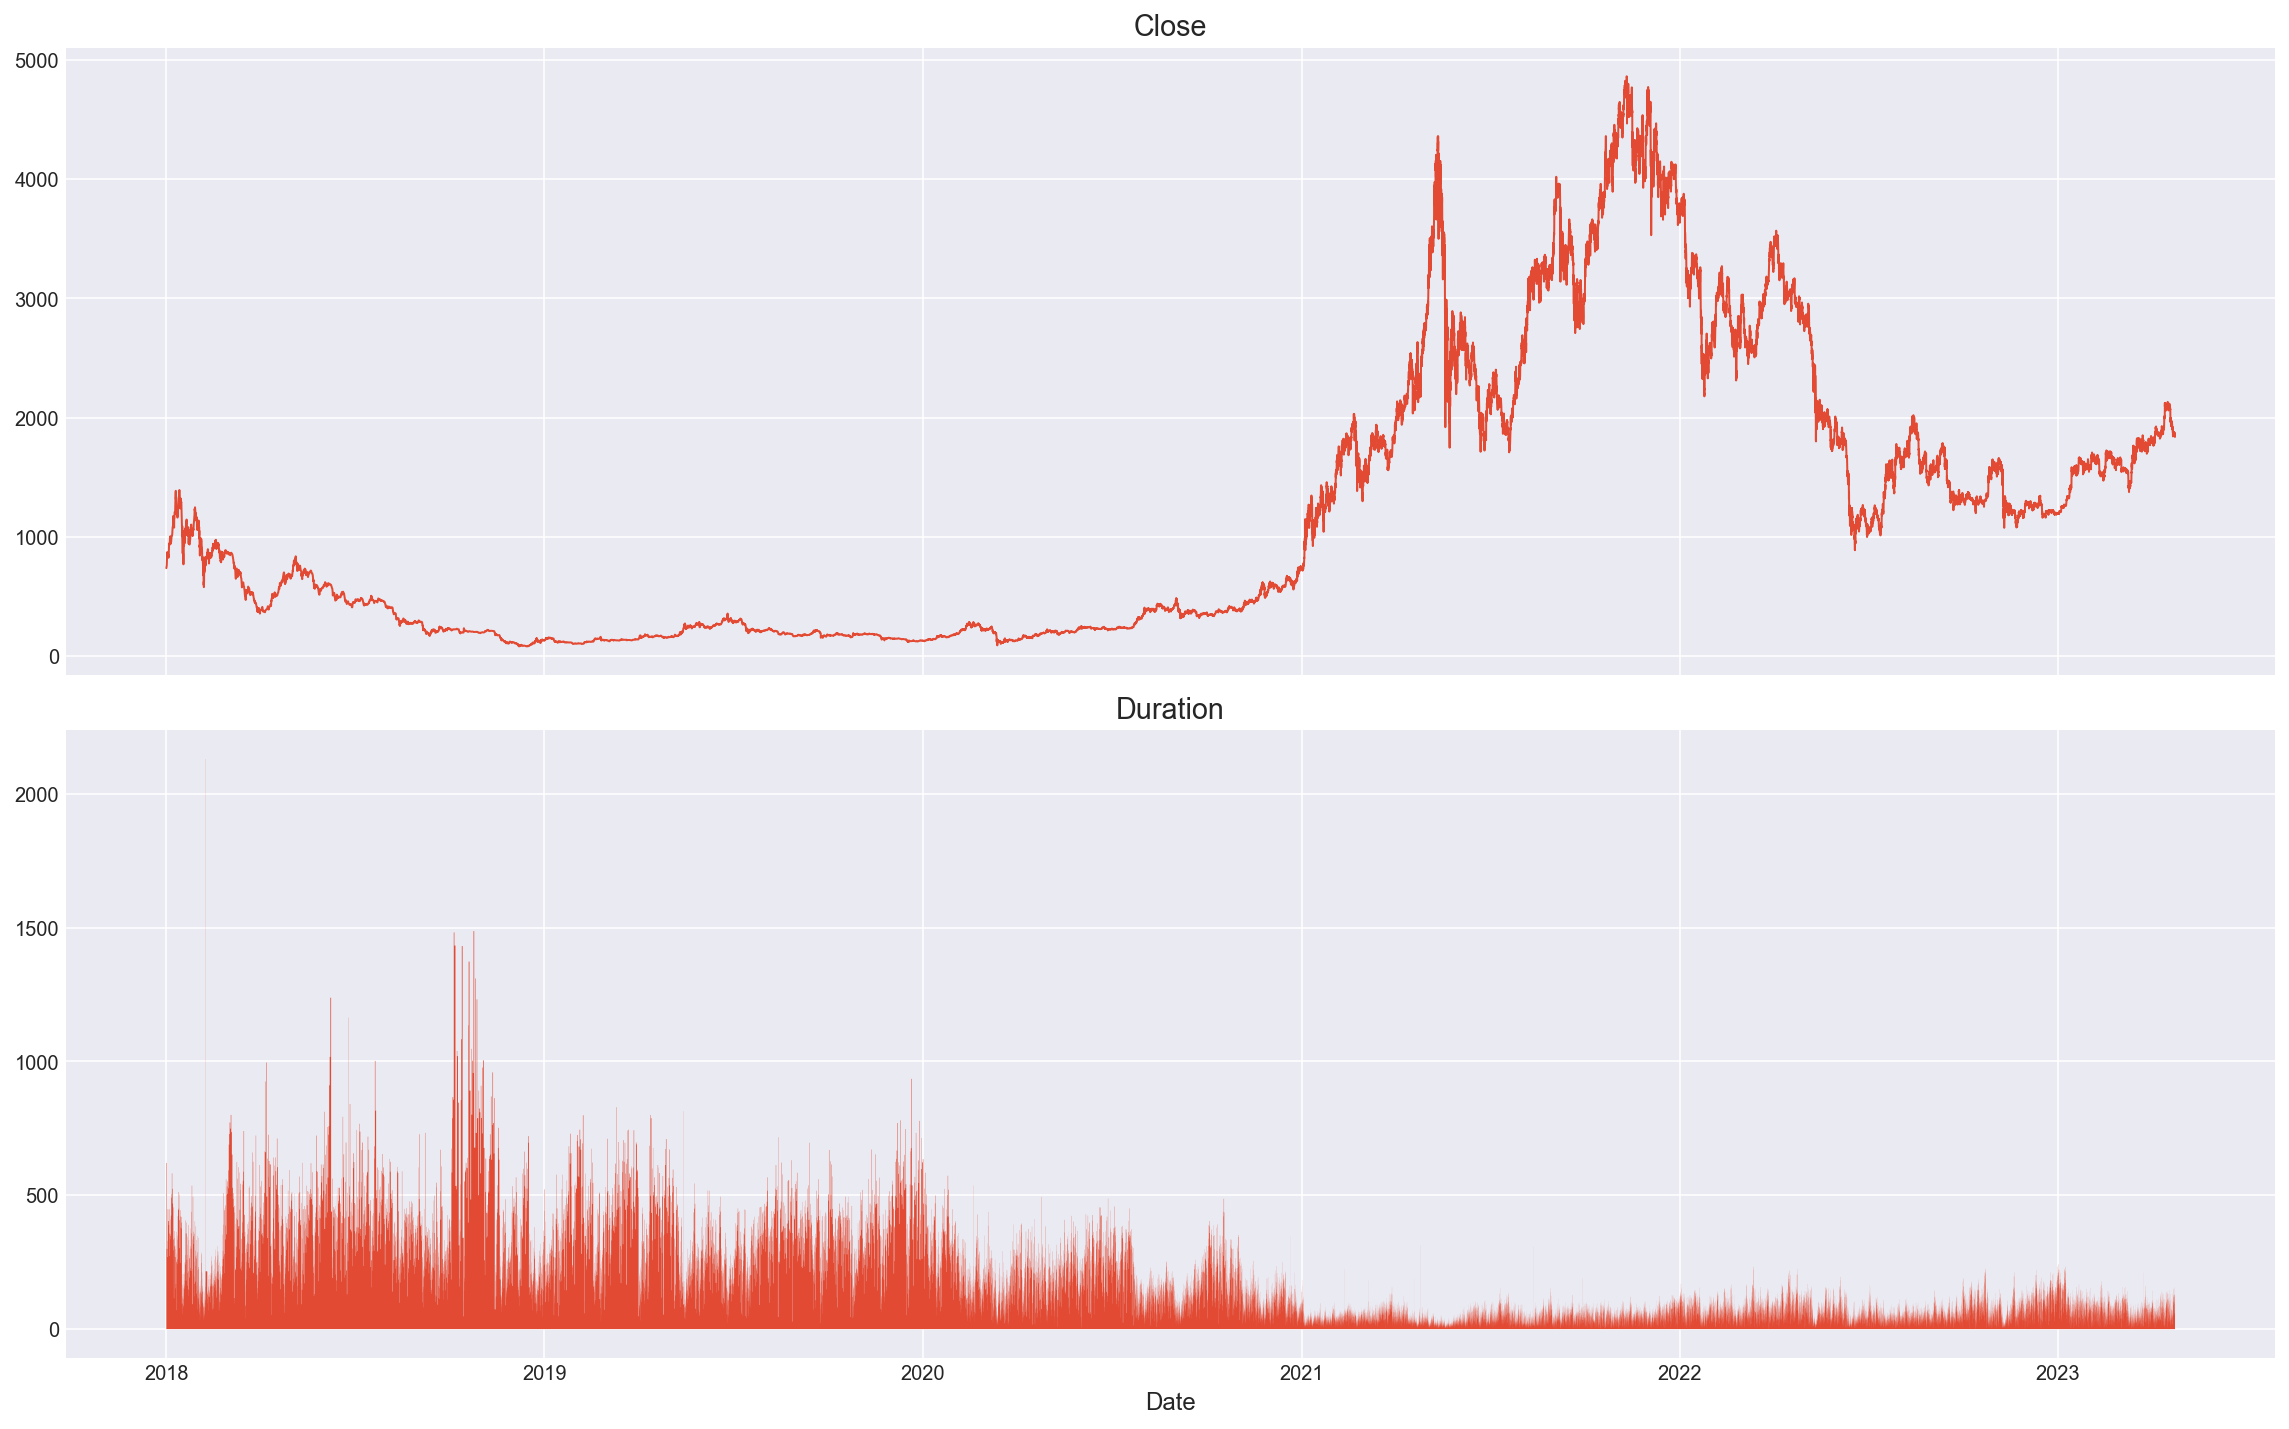

In [104]:
# If need to plot not all data
# df_to_plot = df[df['Begin'] >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot['Begin'].to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Duration'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Duration')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Ощущение, что хотя бы с марта 2020 года надо брать историю

In [105]:
df = df[df['Begin'] >= '2020-03-01'].copy()
df.reset_index(drop=True, inplace=True)

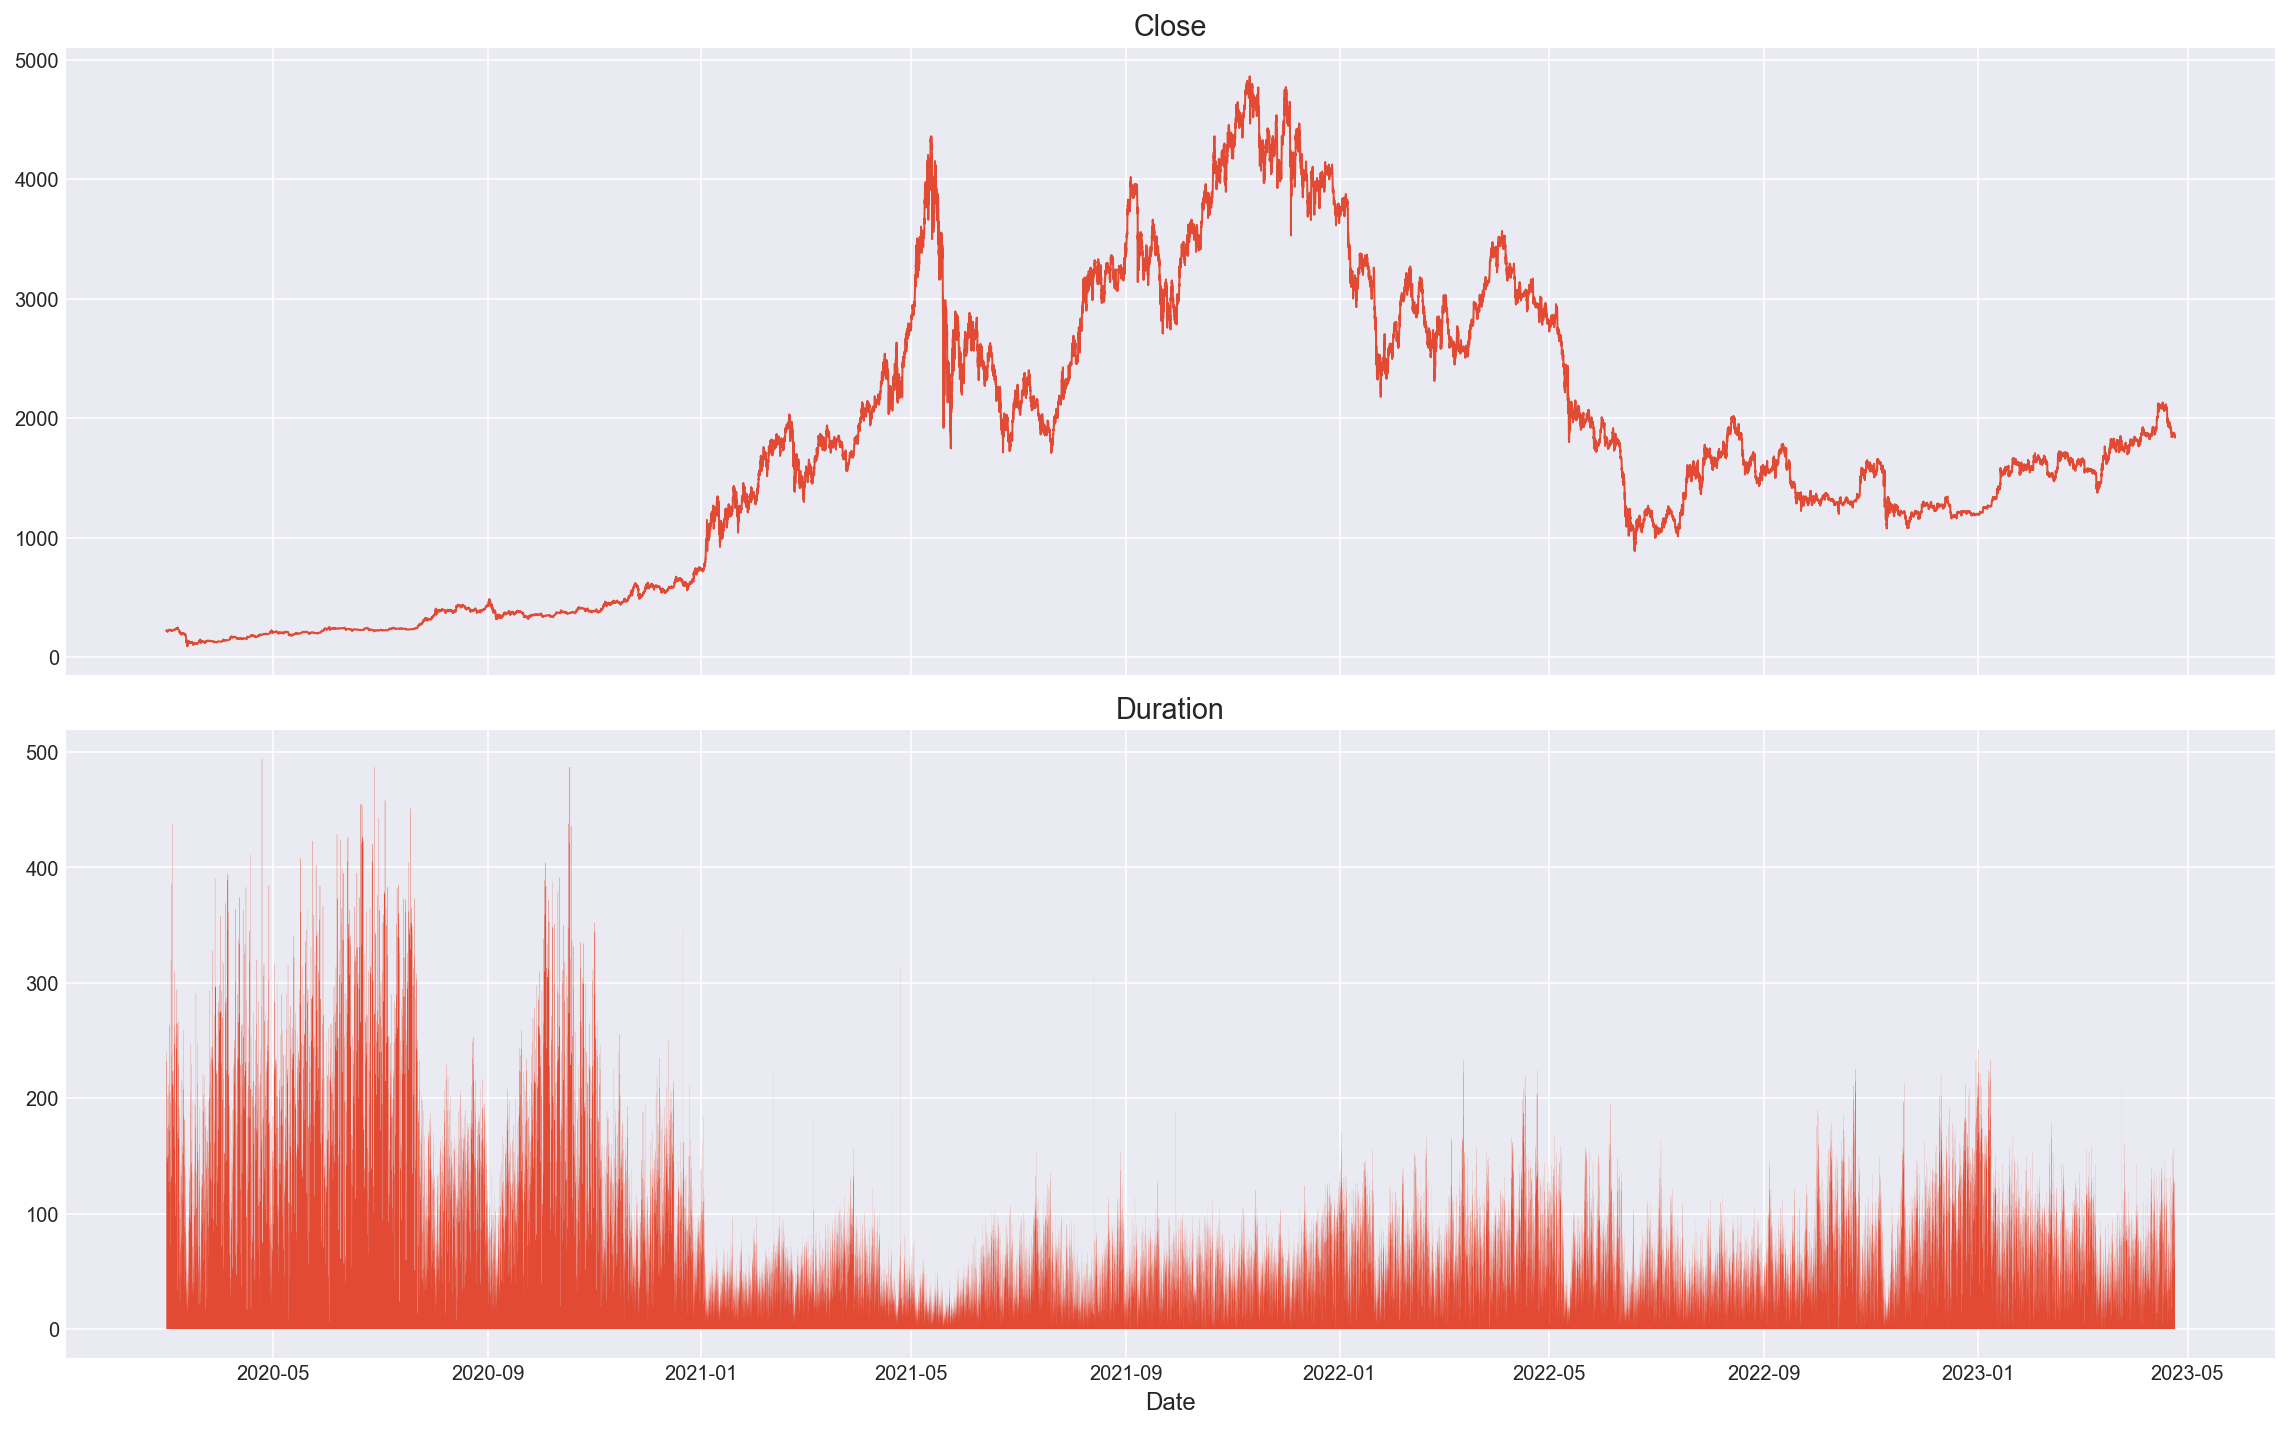

In [106]:
# If need to plot not all data
# df_to_plot = df[df['Begin'] >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot['Begin'].to_numpy()
_0 = df_to_plot['Close'].to_numpy()
_1 = df_to_plot['Duration'].to_numpy()

ax[0].plot(ind, _0, linewidth=1)
ax[0].set_title('Close')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Duration')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

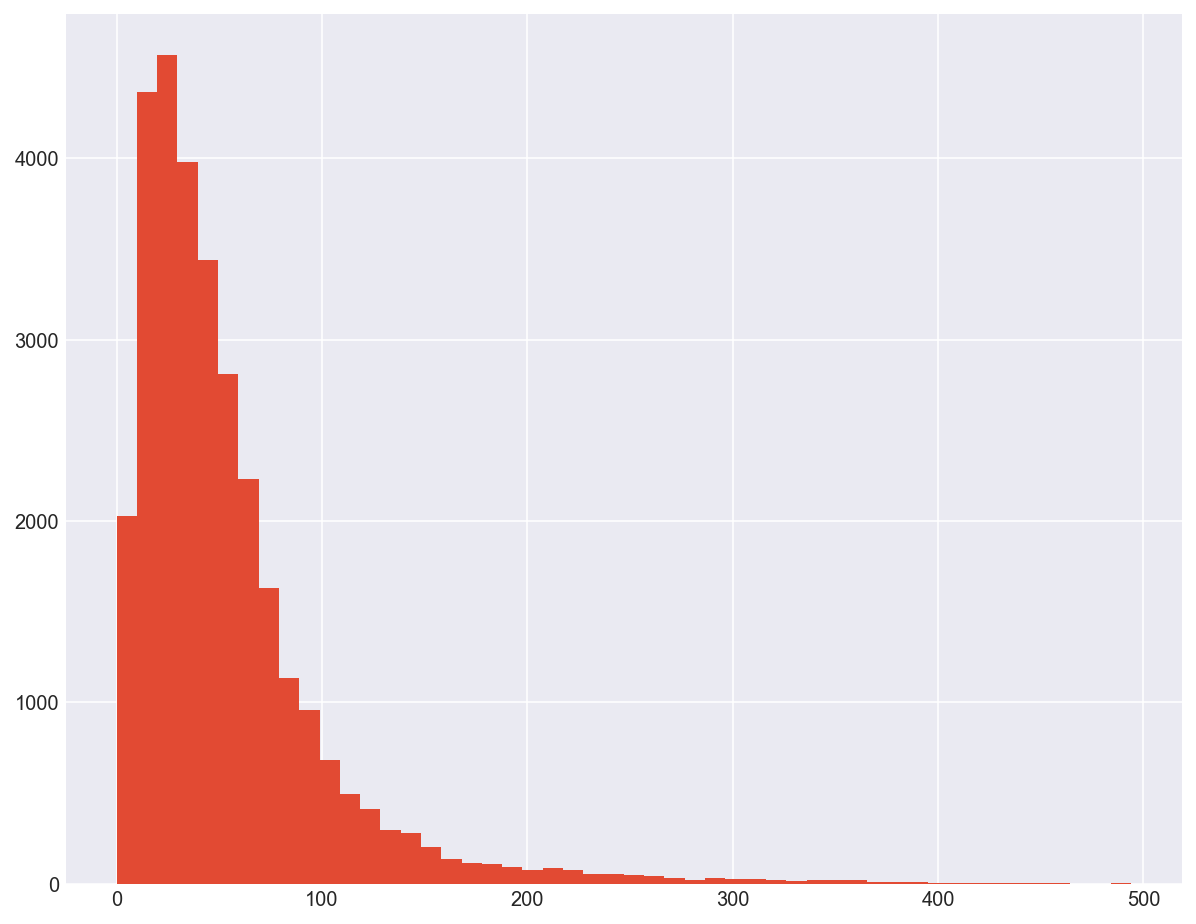

In [107]:
df['Duration'].hist(bins=50);

Посмотрю на бары, которые формировались больше 8ч

In [108]:
mask_8h = df['Duration'] > 60*8

In [109]:
df[mask_8h]

,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
551,2020-04-24 20:37:42.736,188.51,188.90,185.76,187.95,106001.89730,1.983635e+07,494
1007,2020-06-28 01:39:36.226,219.53,223.99,218.32,223.45,115036.54416,2.540282e+07,487
2199,2020-10-17 22:36:43.955,367.88,374.00,367.10,374.00,84802.65391,3.130835e+07,487


In [110]:
ind_8h = df[mask_8h].index.to_list()

In [111]:
sorround = 2
for ind in ind_8h:
    print('Ind:', ind)
    display(df.loc[ind-sorround: ind+sorround])

Ind: 551


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
549,2020-04-24 13:15:01.826,187.02,187.97,184.72,187.64,139280.48948,2.601025e+07,163
550,2020-04-24 15:58:07.029,187.59,189.09,186.41,188.51,106131.26913,1.994838e+07,279
551,2020-04-24 20:37:42.736,188.51,188.90,185.76,187.95,106001.89730,1.983635e+07,494
552,2020-04-25 04:51:49.065,187.95,195.38,187.58,193.91,126112.93107,2.421929e+07,75
553,2020-04-25 06:06:56.658,193.90,196.90,192.86,194.47,124374.03970,2.421692e+07,104


Ind: 1007


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
1005,2020-06-27 19:52:41.260,216.77,220.14,216.59,219.25,106719.46832,2.330402e+07,101
1006,2020-06-27 21:33:51.545,219.25,222.53,218.75,219.53,94818.24587,2.091192e+07,245
1007,2020-06-28 01:39:36.226,219.53,223.99,218.32,223.45,115036.54416,2.540282e+07,487
1008,2020-06-28 09:46:53.037,223.45,225.43,222.05,225.06,99817.94392,2.231276e+07,273
1009,2020-06-28 14:20:48.851,225.06,227.96,224.50,227.12,103816.90833,2.348698e+07,221


Ind: 2199


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
2197,2020-10-17 11:01:28.152,367.76,370.46,364.40,368.02,83111.17883,3.053252e+07,274
2198,2020-10-17 15:35:42.104,368.02,368.35,365.72,367.89,64669.00859,2.372969e+07,421
2199,2020-10-17 22:36:43.955,367.88,374.00,367.10,374.00,84802.65391,3.130835e+07,487
2200,2020-10-18 06:43:54.568,374.00,375.87,371.42,372.59,84493.93254,3.153741e+07,229
2201,2020-10-18 10:33:35.727,372.59,377.30,372.04,375.35,76134.74843,2.852924e+07,321


Ничего необычного, просто бары ночью формируются или под вечер

А что за бары с продолжительностью 0 мин

In [117]:
df[df['Duration'] == 0]

,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
8710,2021-05-13 00:02:19.749,3664.59,3668.84,3500.00,3500.00,16298.78297,5.855831e+07,0
12774,2021-08-05 14:05:41.732,2700.00,2744.99,2698.43,2730.69,12885.05060,3.510769e+07,0
13997,2021-09-03 08:48:46.643,3836.75,3872.38,3833.37,3869.44,9348.48672,3.602122e+07,0
15448,2021-10-14 11:13:36.333,3703.71,3715.00,3691.43,3705.21,4125.90730,1.528575e+07,0
16233,2021-11-02 22:03:09.206,4544.73,4554.02,4523.07,4526.54,4711.26894,2.140715e+07,0
23393,2022-07-16 16:13:50.906,1343.80,1422.91,1343.36,1376.77,36419.10980,5.057275e+07,0
30467,2023-04-14 00:36:42.650,2047.95,2100.00,2047.14,2096.60,20325.06540,4.229680e+07,0


In [118]:
ind_0min = df[df['Duration'] == 0].index.to_list()

In [119]:
sorround = 2
for ind in ind_0min:
    print('Ind:', ind)
    display(df.loc[ind-sorround: ind+sorround])

Ind: 8710


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
8708,2021-05-12 23:59:45.000,3923.07,3940.00,3700.00,3798.73,13870.46535,5.233290e+07,1
8709,2021-05-13 00:00:49.138,3798.73,3820.00,3659.51,3664.59,14561.69944,5.452744e+07,1
8710,2021-05-13 00:02:19.749,3664.59,3668.84,3500.00,3500.00,16298.78297,5.855831e+07,0
8711,2021-05-13 00:03:17.395,3500.00,3692.68,3500.00,3634.93,20161.57395,7.216300e+07,1
8712,2021-05-13 00:05:00.640,3634.93,3780.00,3628.18,3765.04,18690.89217,6.962637e+07,2


Ind: 12774


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
12772,2021-08-05 13:54:56.728,2645.45,2684.18,2643.72,2676.06,16840.02293,4.491350e+07,4
12773,2021-08-05 13:59:11.584,2676.21,2700.00,2666.63,2700.00,14864.44460,3.984435e+07,6
12774,2021-08-05 14:05:41.732,2700.00,2744.99,2698.43,2730.69,12885.05060,3.510769e+07,0
12775,2021-08-05 14:06:36.300,2730.71,2773.56,2728.62,2755.18,16426.43381,4.522215e+07,1
12776,2021-08-05 14:07:49.761,2755.18,2775.00,2747.26,2758.41,19205.73427,5.301817e+07,3


Ind: 13997


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
13995,2021-09-03 06:58:42.377,3789.11,3812.88,3779.97,3800.49,18755.50720,7.119224e+07,55
13996,2021-09-03 07:54:29.280,3800.49,3840.00,3788.98,3836.75,18707.86490,7.125646e+07,54
13997,2021-09-03 08:48:46.643,3836.75,3872.38,3833.37,3869.44,9348.48672,3.602122e+07,0
13998,2021-09-03 08:49:41.575,3868.80,3887.86,3857.88,3875.81,8182.11742,3.170243e+07,1
13999,2021-09-03 08:51:35.057,3875.81,3897.76,3867.61,3880.00,16330.68921,6.344599e+07,9


Ind: 15448


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
15446,2021-10-14 10:36:37.974,3647.81,3690.00,3638.00,3686.51,13055.0194,4.771701e+07,35
15447,2021-10-14 11:12:22.307,3687.23,3703.71,3679.52,3703.71,8505.1469,3.139633e+07,1
15448,2021-10-14 11:13:36.333,3703.71,3715.00,3691.43,3705.21,4125.9073,1.528575e+07,0
15449,2021-10-14 11:14:22.712,3705.21,3716.90,3699.99,3712.87,4658.0907,1.726880e+07,1
15450,2021-10-14 11:16:07.414,3712.87,3732.00,3710.47,3730.05,7922.3501,2.947392e+07,4


Ind: 16233


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
16231,2021-11-02 20:35:26.932,4492.16,4518.53,4479.46,4496.15,12765.93410,5.741518e+07,37
16232,2021-11-02 21:12:50.549,4496.15,4545.00,4483.44,4543.66,10823.84680,4.888352e+07,50
16233,2021-11-02 22:03:09.206,4544.73,4554.02,4523.07,4526.54,4711.26894,2.140715e+07,0
16234,2021-11-02 22:03:53.461,4526.54,4546.10,4524.15,4538.68,2099.47630,9.521381e+06,3
16235,2021-11-02 22:06:54.754,4538.68,4556.75,4529.00,4551.70,7530.49095,3.422778e+07,27


Ind: 23393


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
23391,2022-07-16 16:06:19.219,1300.00,1317.90,1298.32,1310.58,30750.5667,4.019670e+07,4
23392,2022-07-16 16:10:30.848,1310.58,1348.79,1307.64,1343.80,35752.6611,4.757868e+07,3
23393,2022-07-16 16:13:50.906,1343.80,1422.91,1343.36,1376.77,36419.1098,5.057275e+07,0
23394,2022-07-16 16:14:48.322,1377.80,1413.66,1355.57,1368.00,39272.4587,5.447860e+07,1
23395,2022-07-16 16:16:42.202,1368.00,1373.58,1349.18,1351.54,34915.4121,4.755260e+07,2


Ind: 30467


,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration
30465,2023-04-13 22:28:36.939,2013.23,2017.02,2004.08,2010.17,22011.9394,4.424118e+07,113
30466,2023-04-14 00:21:43.488,2010.17,2048.00,2009.22,2047.03,22224.5163,4.505580e+07,14
30467,2023-04-14 00:36:42.650,2047.95,2100.00,2047.14,2096.60,20325.0654,4.229680e+07,0
30468,2023-04-14 00:37:41.528,2096.71,2110.77,2082.54,2110.77,16178.6193,3.390294e+07,2
30469,2023-04-14 00:40:00.855,2110.77,2120.00,2096.27,2111.02,19290.5247,4.069121e+07,2


Надо вернуть продолжительность в сек и посмотреть что тут

### Провека всех признаков исходного ряда на стационарность

In [112]:
# for col_name, col_data in df.items():
#     print('Column Name:', col_name)
#     hd.adf(col_data.values)
#     print()

Column Name: Begin
Test-Statistic: 6.4054416932490374
P-Value: 1.0
Non-Stationary

Column Name: Open
Test-Statistic: -1.9981453552191557
P-Value: 0.28738688790737665
Non-Stationary

Column Name: High
Test-Statistic: -1.9991682214712714
P-Value: 0.28693792411983343
Non-Stationary

Column Name: Low
Test-Statistic: -2.010812746475795
P-Value: 0.28185230383683146
Non-Stationary

Column Name: Close
Test-Statistic: -2.00014760629474
P-Value: 0.2865083827024935
Non-Stationary

Column Name: Vol
Test-Statistic: -3.317761002455847
P-Value: 0.014102985231528819
Stationary!

Column Name: Vol_USD
Test-Statistic: -6.745809037444269
P-Value: 3.0372598882343983e-09
Stationary!

Column Name: Duration
Test-Statistic: -8.079390209103154
P-Value: 1.4753853845057061e-12
Stationary!



Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую все признаки

In [120]:
cols = df.columns[1:-1]
for col in cols:
    df[col + '_log'] = np.log(df[col])

# df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [121]:
df

,Begin,Open,High,Low,Close,Vol,Vol_USD,Duration,Open_log,High_log,Low_log,Close_log,Vol_log,Vol_USD_log
0,2020-03-01 01:16:12.509,217.20,225.69,216.82,223.76,89850.16644,2.001102e+07,174,5.380819,5.419162,5.379068,5.410574,11.405899,16.811793
1,2020-03-01 04:10:24.611,223.75,223.75,218.70,220.02,87210.77563,1.927677e+07,240,5.410529,5.410529,5.387701,5.393718,11.376083,16.774411
2,2020-03-01 08:10:39.236,220.03,227.00,218.90,227.00,86360.98917,1.917375e+07,232,5.393764,5.424950,5.388615,5.424950,11.366291,16.769053
3,2020-03-01 12:03:24.069,226.99,227.89,219.61,221.78,97067.57270,2.164456e+07,149,5.424906,5.428863,5.391853,5.401686,11.483163,16.890264
4,2020-03-01 14:33:13.395,221.80,221.93,214.66,217.16,98955.71598,2.157298e+07,145,5.401776,5.402362,5.369055,5.380634,11.502428,16.886952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30681,2023-04-23 15:14:23.803,1860.00,1863.46,1847.94,1852.54,25615.26410,4.757427e+07,60,7.528332,7.530190,7.521827,7.524313,10.150944,17.677803
30682,2023-04-23 16:15:07.584,1852.56,1872.69,1852.55,1857.59,20070.28670,3.741527e+07,95,7.524324,7.535131,7.524318,7.527035,9.906996,17.437590
30683,2023-04-23 17:50:13.896,1857.59,1861.52,1836.37,1838.80,25799.06150,4.776911e+07,60,7.527035,7.529149,7.515546,7.516868,10.158093,17.681890
30684,2023-04-23 18:50:34.308,1838.80,1852.35,1838.43,1840.21,25428.22350,4.694859e+07,72,7.516868,7.524210,7.516667,7.517635,10.143615,17.664564


Тени от открытия бара на лог шкале

In [122]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [123]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [124]:
risk_level = 0.0025
profit_factor = 4
profit_level = risk_level * profit_factor
TARGET = 'Long'

In [125]:
zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
print('Метрика Precision должна быть выше:', zero_mo)

Метрика Precision должна быть выше: 0.2


In [126]:
df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)

Анализ распределения классов целевого признака

In [127]:
class_df = pd.DataFrame({'%': (df[TARGET].value_counts(True) * 100).round(2), 'Count': df[TARGET].value_counts()})
class_df.index.name = 'Class'
class_df.sort_index(ascending=False, inplace=True)
class_df
    

,%,Count
Class,,
1,12.17,3736
0,87.83,26950


На той же длине истории, но часовые бары показатели такие

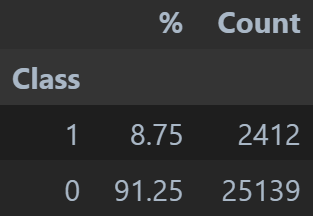

Т.е. вижу и баров больше и класс чуть более сбалансированный

# Feature Engineering
* Преобразую исходные данные
* Получаю новые признаки. 
* Удаляю ненужные.
* Обогощаю данные.

* Объемы и сделки:
Можно считать средний объем сделки. 
- AvrTrade = Volume / Trades
- Объем в долларах, т.е. нормированный объем VolUSD = Volume * Close
- Объем на единицу диапазона.

### Базовая модель - оставляю в качестве признака только Log_Return и целевой признак

In [68]:
df_new = df[['Log_Return', TARGET]].copy()

# Transform TimeSeries to Dataset for Supervised Learning
Тут определяется глубина последовательности данных, которая будет использоваться для построения прогноза T. Временное окно в прошлое.

Т это так же гиперпараметр, его так же нужно будет искать по сетке.

In [69]:
T = 12 # len of sequence. Num of time steps to look at to make prediction on next step

Create $X$, $y$

In [70]:
X, y = hd.create_X_y_from_timeseries(df_new, TARGET, T)

In [71]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (46404, 12) y.shape: (46404,)


# Split Data
Разбиение с стратифиацией

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Outliers
Обработка выбросов. Пробовать прорядить выборку удалением записей по методу:
- 3х сигм
- методу Тьюки
- Isolation Forest
- Local Outlier Factor
- Minimun Covariance Determinant

Но обработку надо делать уже после разделения выборки на train/test

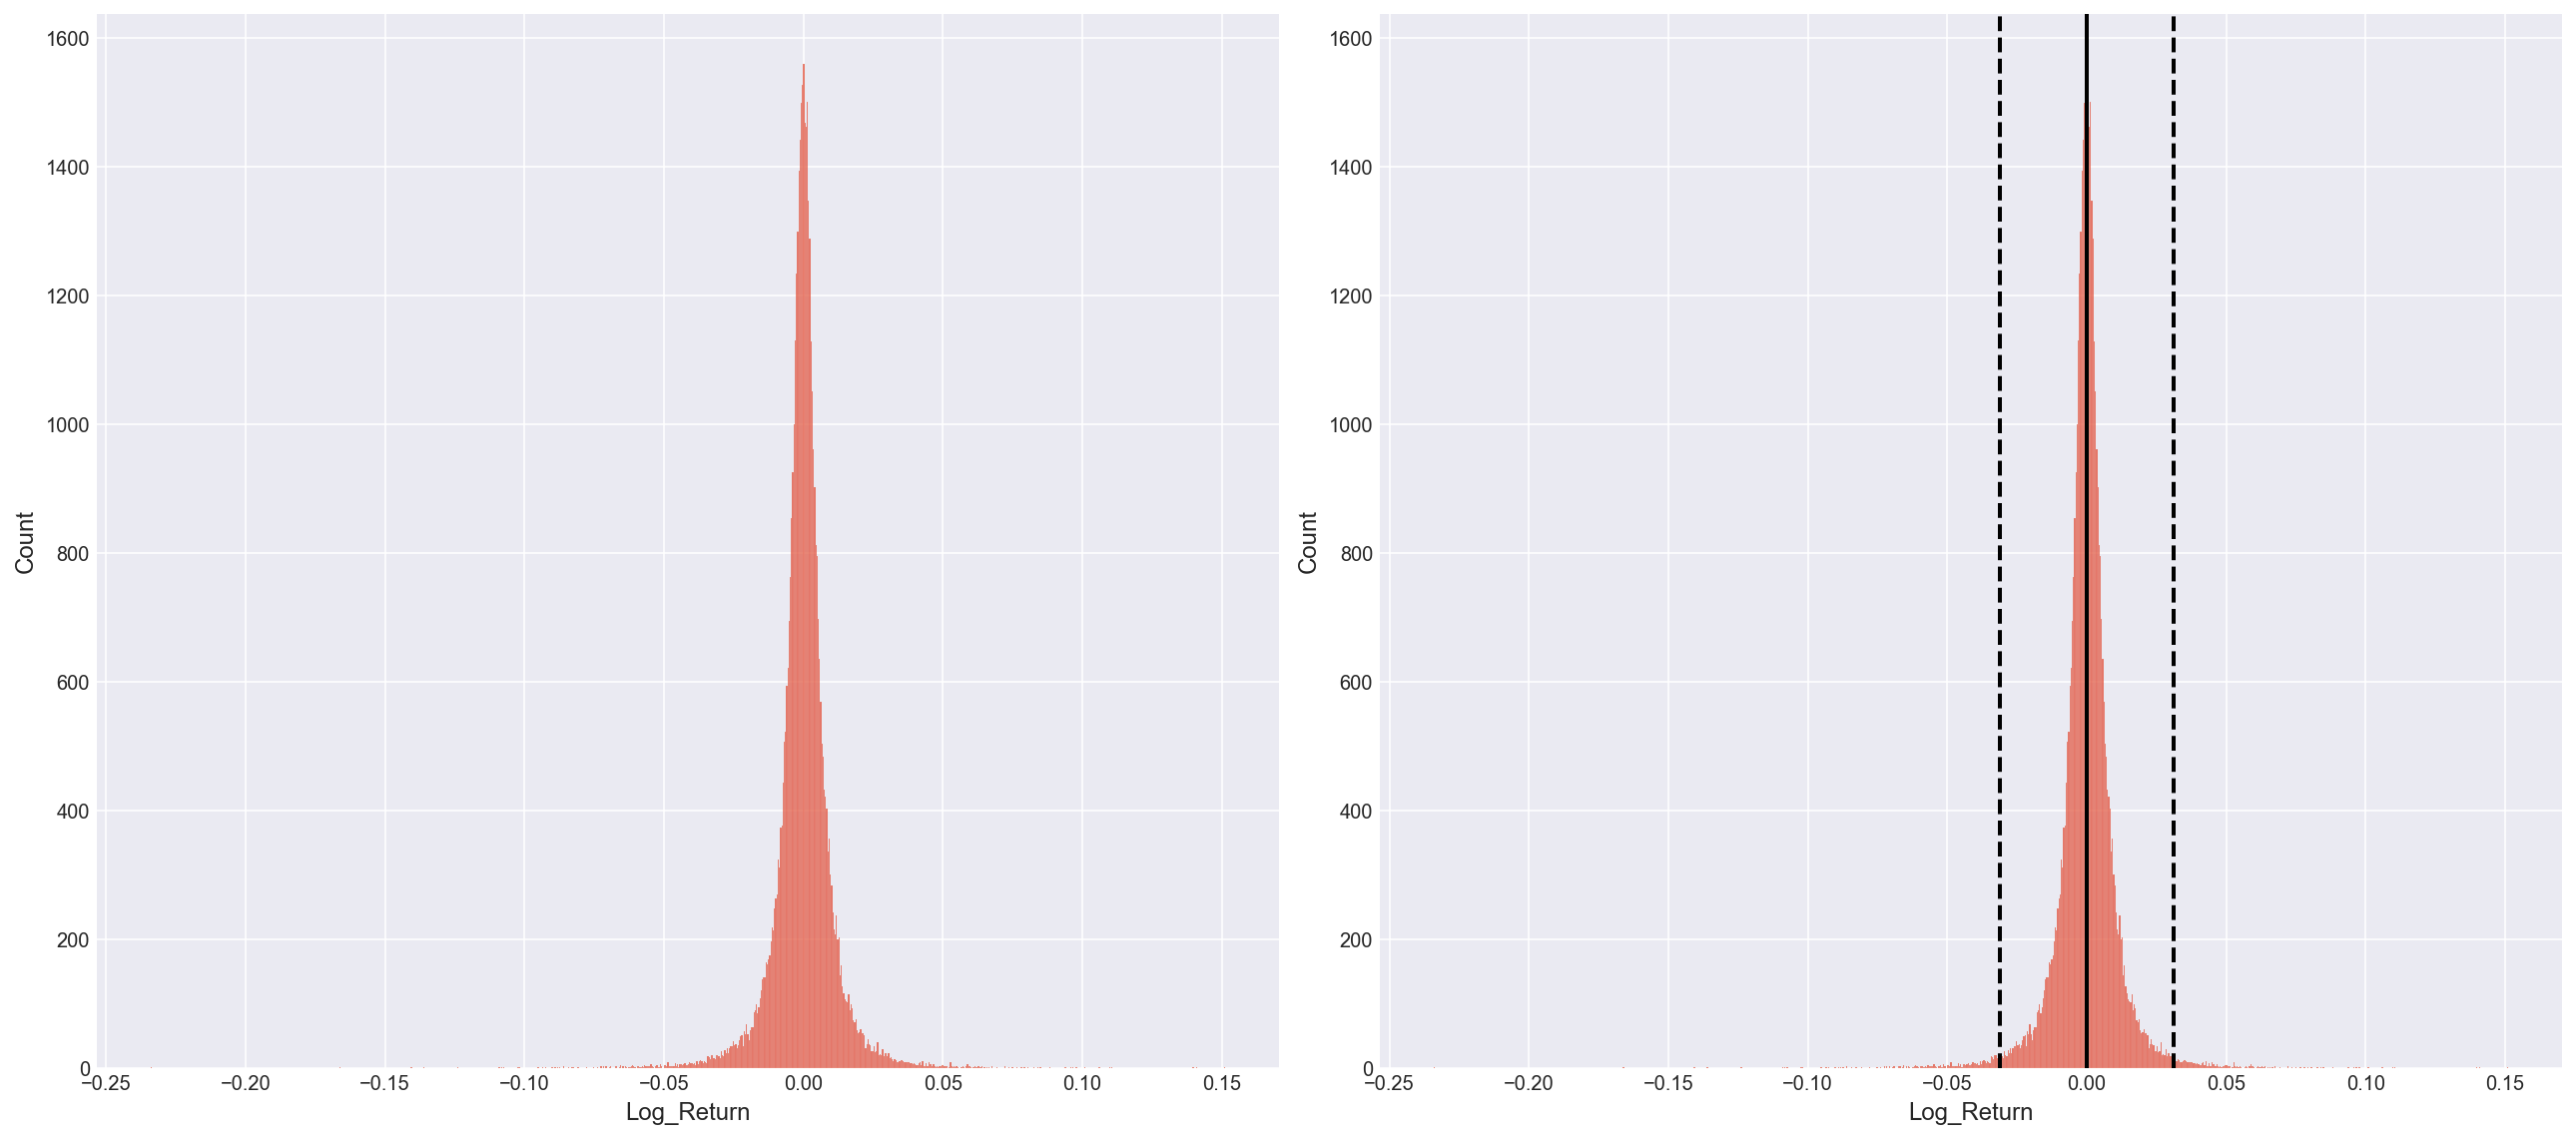

In [73]:
hd.plot_outliers_z_score(df_new, 'Log_Return', log_scale=False) # log_scale=False т.к. цены были изначально прогалорифмированы и затем еще и разница посчитана

Распределение выглядит максимально равномерно. 
Позже, на последующих итерациях можно думать о том, что бы обрезать хвосты и посмотреть как это отразится на результатах модели.

# Scaling Data
Нужно скалировать признаки, приводить их к одному масштабу. Путем перебора выбирать лучший скалер.

In [74]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create Model

In [75]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [76]:
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.532
Precision: 0.103
Recall: 0.535
F1: 0.173

*** TEST ***
Accuracy: 0.525
Precision: 0.102
Recall: 0.539
F1: 0.172


In [77]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

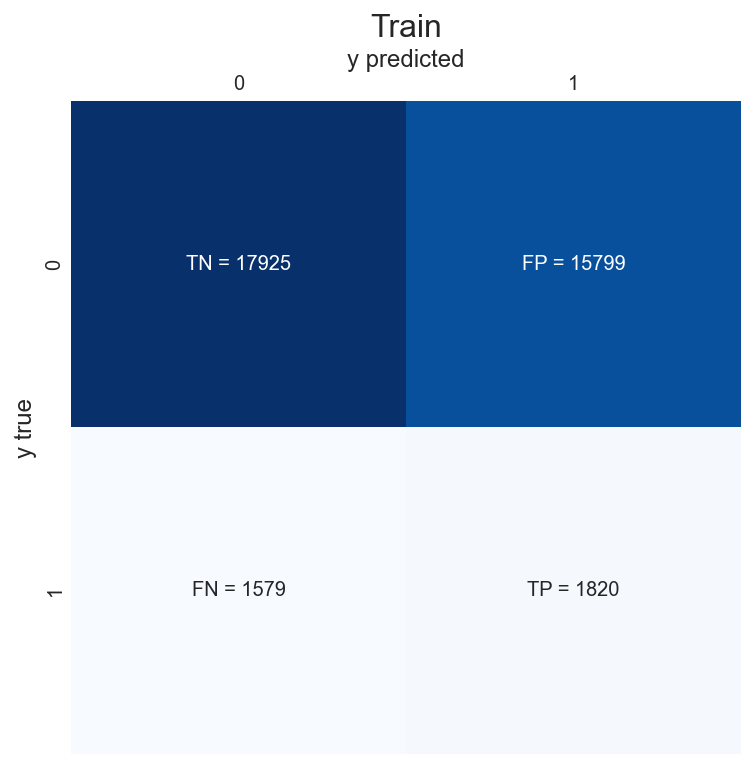

In [78]:
hd.plot_confusion_matrix(cm_train, 'Train')

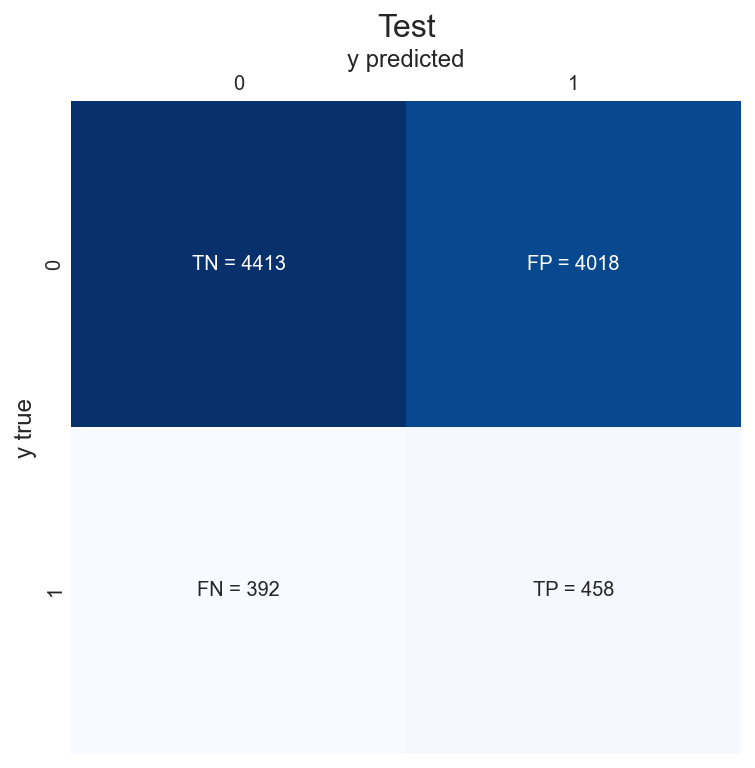

In [79]:
hd.plot_confusion_matrix(cm_test, 'Test')

In [80]:
pd.Series(y_test).value_counts()

0.0    8431
1.0     850
Name: count, dtype: int64

In [81]:
pd.Series(y_test_pred).value_counts()

0.0    4805
1.0    4476
Name: count, dtype: int64

Видно, что я очень много предсказываю класс 1, надо сильно меньше. Нужно на Precision фокусироваться.

Вот такая базовая модель.

Precision 0.101. Т.е. точность всего 10%.

*** TRAIN ***
Accuracy: 0.531
Precision: 0.104
Recall: 0.540
F1: 0.174

*** TEST ***
Accuracy: 0.528
Precision: 0.101
Recall: 0.524
F1: 0.169

# Случайный лес
подбор параметров вручную

In [82]:
rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=5, class_weight='balanced')
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
hd.print_classification_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
Accuracy: 0.614
Precision: 0.143
Recall: 0.645
F1: 0.234

*** TEST ***
Accuracy: 0.590
Precision: 0.124
Recall: 0.573
F1: 0.204


Моя задача это что бы Precision был больше нулевой точки матожидания.
Как свою метрику можно использовать разницу Precision-zero_mo. Чем она ближе к нулю, тем лучше. В идеале она должна быть положительной.

Так же мне нужно переводить метки в реальный подсчет результатов сделок, то что я начинал делать в ноутбуке Calulate_Result.
Ведь даже если по метрикам я промазал и был FP прогноз, это еще не значит что сделка была бы убыточной.

Нужно брать предсказанные метки, как-то соединять их с датафреймом и считать результаты сделок 

### Что я могу делать дальше:
- Добавление признаков, сейча используется лишь Log_Return. Добавляю ценовые признаки, для начала размеры теней, которые исопльзовались для генерации целевого признака
- Признак диапазона бара, размера тела в % к диапазону.
- Добавление признаков сгенерированных из даты.
- Добавление признаков сгенерированных из торгового объема.
- генерация целевого признака по сетке параметров risk_level = 0.0025, profit_factor = 4. Изучение значений Precision, zero_mo и их разницы
- обход основных моделей ML для классификации
- Из вектора предсказанных меток получение результатов торговли, надо как-то метки совмещать опять с исходным датафреймом. где бы можно было бы считать результаты торговли